In [90]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sp
import scipy.io.wavfile as wavfile
from pydio import *
import sounddevice as sd
import soundfile as sf


In [5]:
# parameters
N = 8 # number of microphones
d = 0.05 # distance between microphones
c = 343 # speed of sound
f = 2000 # frequency 
fs = 44100 # sampling frequency

direction = 70 # tuned beamformer angle in degrees

resolution = 180*5 # resolution of theoretical beampattern and simulation

# theoretical Delay and Sum beamforming

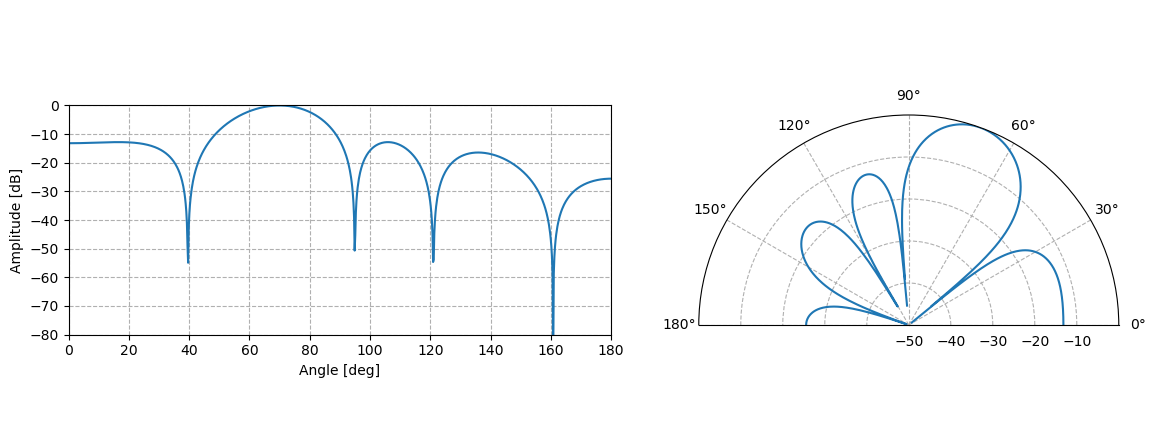

In [6]:

angle_theo = np.linspace(0,180,resolution)

# amplitude of theoretical beampattern
A_theo = np.zeros((resolution),dtype=complex)

for angle in range(0,resolution):
    
    A_theo[angle] = np.abs((np.sin(N*np.pi*f*d*(np.cos(np.radians(angle_theo[angle]))-np.cos(np.radians(direction)))/c)) / 
                           (N*np.sin(np.pi*f*d*(np.cos(np.radians(angle_theo[angle]))-np.cos(np.radians(direction)))/c)))



#plot_cartesian(angle_theo, 20*np.log10(A), 'Theoretical_beampattern_cartesian')
#plot_polar(angle_theo, 20*np.log10(A), 'Theoretical_beampattern_polar')
plot_combi(angle_theo, 20*np.log10(A_theo), 'Theoretical_beampattern')



C:\Users\claes\AppData\Local\Temp\ipykernel_15680\3355261332.py:5: RuntimeWarning: invalid value encountered in true_divide
  A = 20*np.log10(np.abs((np.sin(N*np.pi*freq*d*(np.cos(np.radians(angle_theo))-np.cos(np.radians(direction)))/c)) /


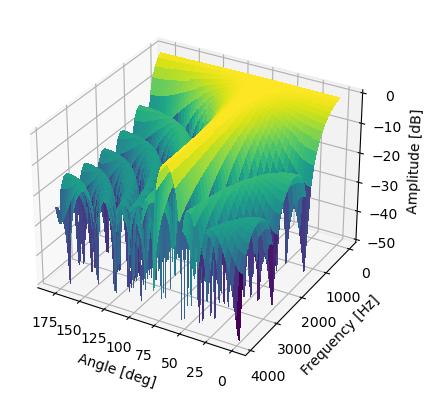

In [7]:
# Make data.
freq = np.arange(0, 4000, 100)
angle, freq = np.meshgrid(angle_theo, freq)

A = 20*np.log10(np.abs((np.sin(N*np.pi*freq*d*(np.cos(np.radians(angle_theo))-np.cos(np.radians(direction)))/c)) / 
                       (N*np.sin(np.pi*freq*d*(np.cos(np.radians(angle_theo))-np.cos(np.radians(direction)))/c))))
A[A<-50]= np.nan # remove values below -60 dB


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(angle, freq, A, cmap='viridis',
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-50, 0)

ax.set_xlabel('Angle [deg]')
ax.set_ylabel('Frequency [Hz]')
ax.set_zlabel('Amplitude [dB]')
# view direction
ax.view_init(30, 120)
plt.savefig('plots/Theoretical_beampattern_3D.svg')
#plt.show()

# Simulation of the delay and sum beamforming

by creating a test signal that is artificially delayed depending on angle

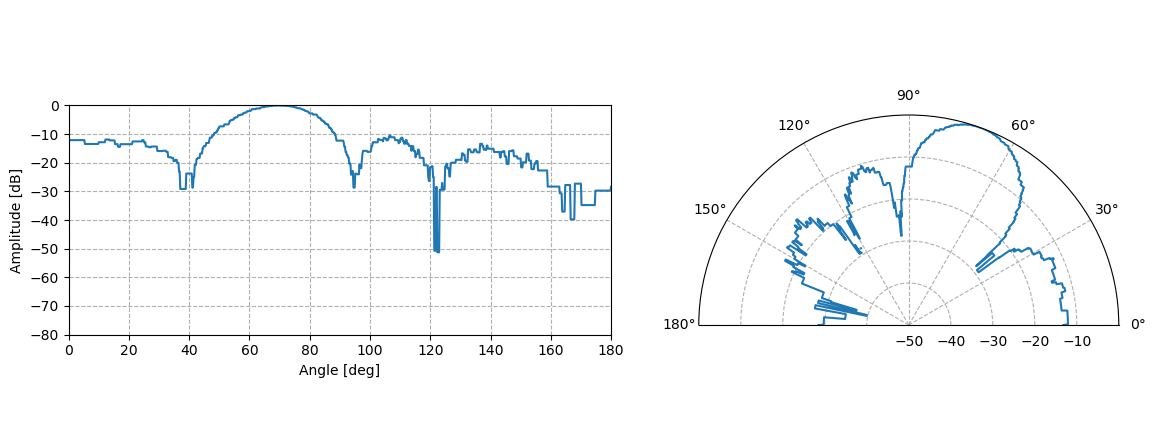

In [8]:

# simulation test signal
t = np.linspace(0, 10, fs)
x = np.sin(2*np.pi*f*t)


angle_sim = np.linspace(0,180,resolution)


simulation = np.zeros((resolution,len(t)))
for angle in range(0,resolution):
    mic = collectPlaneWave(8, 0.05,angle_sim[angle],x,fs,c=343)
    
    for i in range(0,8):
        mic[i] = np.roll(mic[i], int(fs*(Fn((8-i),0.05,direction))))
    simulation[angle] = np.sum(mic, axis=0)

# FFT
FFT_simulation = np.zeros((resolution,len(t)),dtype=complex)
for angle in range(0,resolution):
    FFT_simulation[angle] = np.fft.fft(simulation[angle])
freq_simulation = np.fft.fftfreq(len(t), 1/fs)

# plot

#plot_cartesian(np.linspace(0, 180, resolution), 20*np.log10(np.abs(FFT_simulation[:,freq_simulation==f])/np.max(np.abs(FFT_simulation[:,freq_simulation==f]))), 'Simulation_beampattern_cartesian')
#plot_polar(np.linspace(0, 180, resolution), 20*np.log10(np.abs(FFT_simulation[:,freq_simulation==f])/np.max(np.abs(FFT_simulation[:,freq_simulation==f]))), 'Simulation_beampattern_polar')
plot_combi(np.linspace(0, 180, resolution), 20*np.log10(np.abs(FFT_simulation[:,freq_simulation==f])/np.max(np.abs(FFT_simulation[:,freq_simulation==f]))), 'Simulation_beampattern')


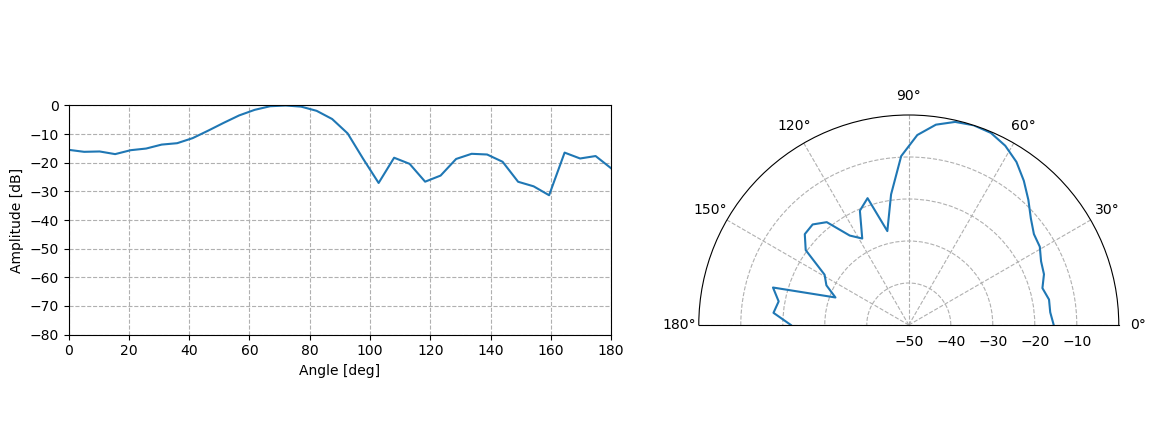

In [9]:
resolution_measurement = int(180/5)

# microphone equalization coefficients 
a = equalizationCoefficients('data/measurement_2k_no_noise_0_180_5deg/90_deg.wav')

# define measurement array
fs, sig = wavfile.read('data/measurement_2k_no_noise_0_180_5deg/' + str(0) + '_deg.wav')
measurement = np.zeros((resolution_measurement,len(sig)))


for angle in range(0,resolution_measurement):
    fs, sig = wavfile.read('data/measurement_2k_no_noise_0_180_5deg/' + str(angle*5) + '_deg.wav')

    # remove the last channel as it is the reference channel
    sig = np.delete(sig, 8, axis=1)

    for i in range(0,8):
        sig[:,i] = np.roll(sig[:,i], int(fs*(Fn((8-i),0.05,direction))))*a[i] # apply equalization coefficients

    measurement[angle] = np.sum(sig, axis=1)

# FFT
FFT_measurement = np.zeros((resolution_measurement,len(sig)),dtype=complex)
for angle in range(0,resolution_measurement):
    FFT_measurement[angle] = np.fft.fft(measurement[angle])
freq_measurement = np.fft.fftfreq(len(sig), 1/fs)

# plot

#plot_cartesian(np.linspace(0, 180, resolution_measurement), 20*np.log10(np.abs(FFT_measurement[:,freq_measurement==f])/np.max(np.abs(FFT_measurement[:,freq_measurement==f]))), 'Measurement_beampattern_cartesian')
#plot_polar(np.linspace(0, 180, resolution_measurement), 20*np.log10(np.abs(FFT_measurement[:,freq_measurement==f])/np.max(np.abs(FFT_measurement[:,freq_measurement==f]))), 'Measurement_beampattern_polar')
plot_combi(np.linspace(0, 180, resolution_measurement), 20*np.log10(np.abs(FFT_measurement[:,freq_measurement==f])/np.max(np.abs(FFT_measurement[:,freq_measurement==f]))), 'Measurement_beampattern')

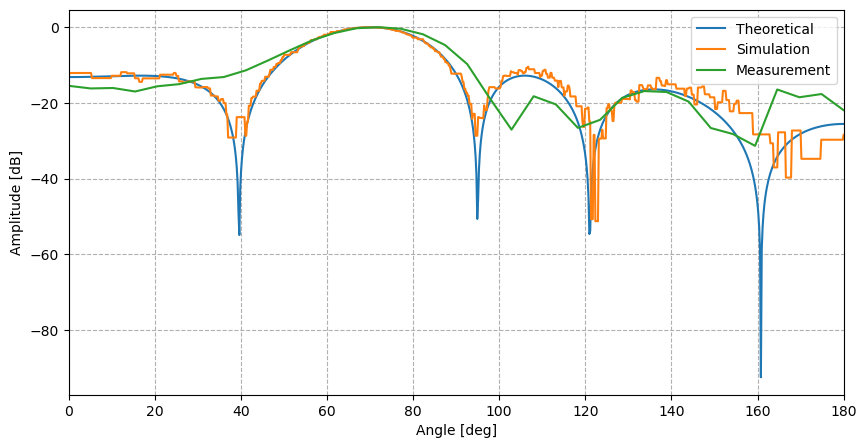

In [209]:
# comparison plot cartesian

plt.figure(figsize=(10,5))
plt.plot(angle_theo, 20*np.log10(A_theo), label='Theoretical')
plt.plot(np.linspace(0, 180, resolution), 20*np.log10(np.abs(FFT_simulation[:,freq_simulation==f])/np.max(np.abs(FFT_simulation[:,freq_simulation==f]))),label='Simulation')
plt.plot(np.linspace(0, 180, resolution_measurement), 20*np.log10(np.abs(FFT_measurement[:,freq_measurement==f])/np.max(np.abs(FFT_measurement[:,freq_measurement==f]))), label='Measurement')

plt.xlabel('Angle [deg]')
plt.ylabel('Amplitude [dB]')
plt.xlim([0, 180])
plt.grid(True, linestyle='--')
plt.legend()
#plt.savefig('plots/Comparison_beampattern_cartesian.svg')



<Figure size 640x480 with 0 Axes>

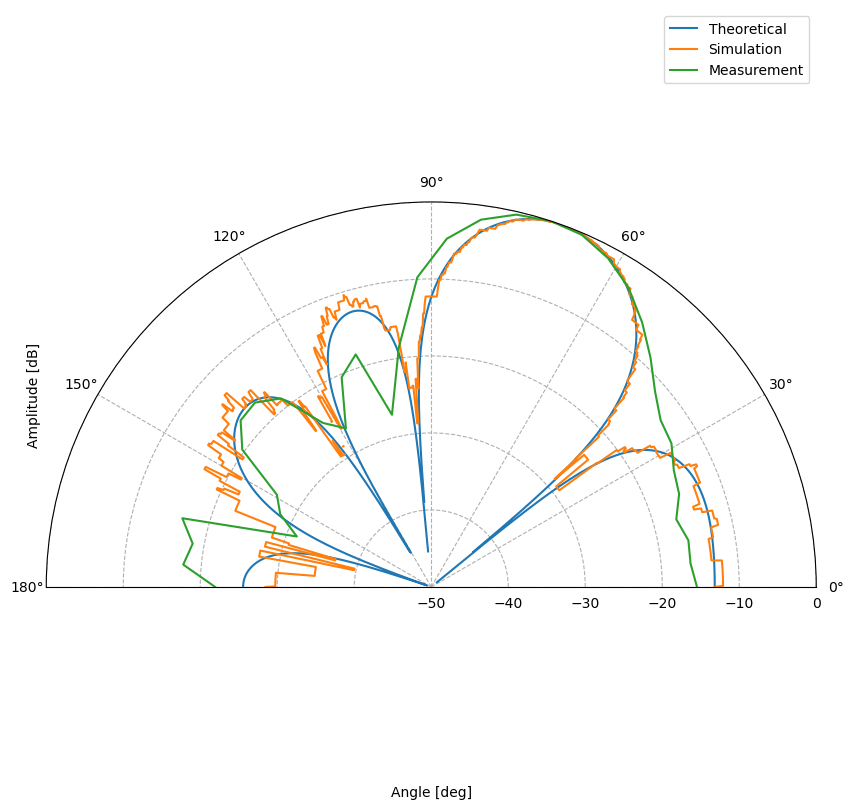

In [11]:
# comparison plot polar

plt.figure()

fig, ax = plt.subplots(figsize=(10,10),subplot_kw={'projection': 'polar'})

ax.plot(np.radians(angle_theo), 20*np.log10(A_theo), label='Theoretical')
ax.plot(np.radians(np.linspace(0, 180, resolution)), 20*np.log10(np.abs(FFT_simulation[:,freq_simulation==f])/np.max(np.abs(FFT_simulation[:,freq_simulation==f]))),label='Simulation')
ax.plot(np.radians(np.linspace(0, 180, resolution_measurement)), 20*np.log10(np.abs(FFT_measurement[:,freq_measurement==f])/np.max(np.abs(FFT_measurement[:,freq_measurement==f]))), label='Measurement')

ax.set_xlabel('Angle [deg]')
ax.set_ylabel('Amplitude [dB]')
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_rticks([0, -10, -20,-30, -40, -50])
ax.set_ylim([-50, 0])
ax.set_rlabel_position(-22.5)
ax.grid(True, linestyle='--')
ax.legend()
plt.savefig('plots/Comparison_beampattern_polar.svg')


# delay and sum beamforming reel speech
## simulation

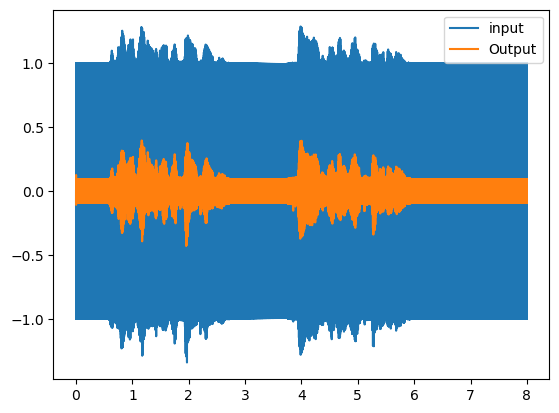

In [219]:



tx, samplerate = sf.read("data/P501_C_english_m1_FB_48k.wav")

t = np.linspace(0, len(tx)/samplerate, len(tx))
noise = np.sin(2*np.pi*f*t)*1



mic = collectPlaneWave(8, 0.05,70,tx,samplerate)
mic += collectPlaneWave(8, 0.05,150,noise,samplerate)
   
for i in range(0,8):
    mic[i] = np.roll(mic[i], int(samplerate*(Fn((8-i),0.05,direction))))

output = np.sum(mic, axis=0)/8



#sd.play(np.sum(mic, axis=0)/8, samplerate)

plt.plot(t, mic[0],label='input')

#plt.plot(t, tx, label='Input')
plt.plot(t, output, label='Output')

plt.legend()

In [217]:
20*np.log10(np.sqrt(np.mean(output[0:1000]**2))/np.sqrt(np.mean(mic[0,0:1000]**2)))

-20.54435245771588

## experiment

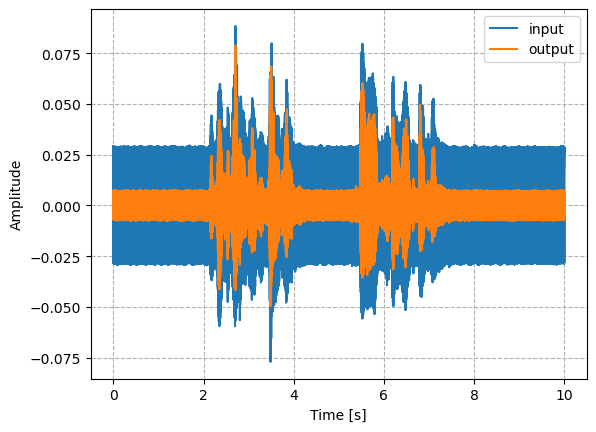

In [248]:
input, samplerate = sf.read("data/measurement_2k_noise_high_amplitude_speach_signal/2k_noise__60_deg_speach_signal_20_deg.wav")

# microphone equalization coefficients 
a = equalizationCoefficients('data/measurement_2k_no_noise_0_180_5deg/90_deg.wav')

mic = input.T

#sd.play(mic[0], samplerate)
for i in range(0,8):
    mic[i] = np.roll(mic[i], int(samplerate*(Fn((8-i),0.05,direction))))*a[i]

output = np.sum(mic, axis=0)/8
#sd.play(output, samplerate)


t = np.linspace(0, len(input.T[0])/samplerate, len(input.T[0]))

plt.plot(t,input.T[0],label='input')
plt.plot(t,output,label='output')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, linestyle='--')
plt.savefig('plots/das_Output_signal.pdf')






In [207]:
20*np.log10(np.sqrt(np.mean(output[0:1000]**2))/np.sqrt(np.mean(input.T[0,0:1000]**2)))


-12.29274484120424

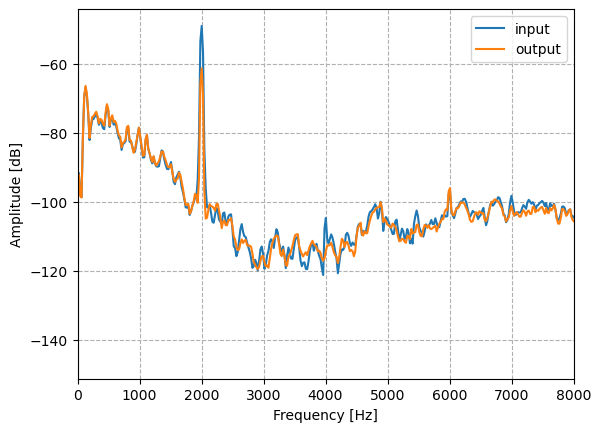

In [246]:
# fft 


#FFT_input = np.fft.fft(input.T[0])
#freq_input = np.fft.fftfreq(len(input.T[0]), 1/samplerate)

#FFT_output = np.fft.fft(output)
#freq_output = np.fft.fftfreq(len(output), 1/samplerate)


#plt.plot(freq_input, 20*np.log10(np.abs(FFT_input)/np.max(np.abs(FFT_input))),label='input')
#plt.plot(freq_output, 20*np.log10(np.abs(FFT_output)/np.max(np.abs(FFT_output))),label='output')

freq, fft_input = sp.signal.welch(input.T[0],samplerate, nperseg=1024*2)
freq, fft_output = sp.signal.welch(output,samplerate, nperseg=1024*2)
plt.plot(freq, 10*np.log10(fft_input),label='input')
plt.plot(freq, 10*np.log10(fft_output),label='output')
#plt.plot(freq,(fft_input),label='input')
#plt.plot(freq, (fft_output),label='output')
plt.xlim(0,8000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.grid(True, linestyle='--')
plt.savefig('plots/das_Output_signal_fft.pdf')


In [223]:
print(np.max(10*np.log10(fft_input)))
print(np.max(10*np.log10(fft_output)))
print(np.max(10*np.log10(fft_input))-np.max(10*np.log10(fft_output)))

-49.036300334332275
-61.30619071168344
12.269890377351167


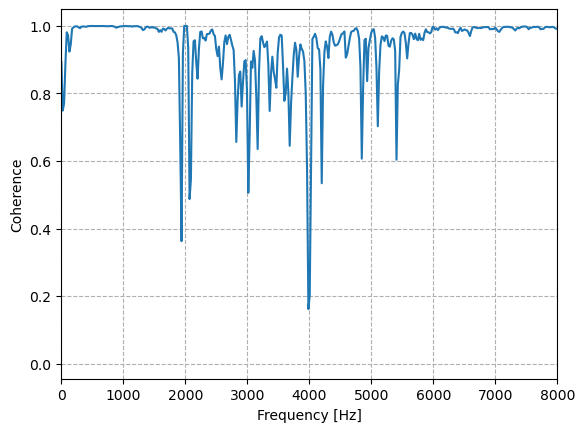

In [247]:
freq, coherence =signal.coherence(input.T[0],output,fs=samplerate,nperseg=1024*2)
plt.plot(freq, coherence)
plt.xlim(0,8000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.grid(True, linestyle='--')
plt.savefig('plots/das_Output_signal_coherence.pdf')

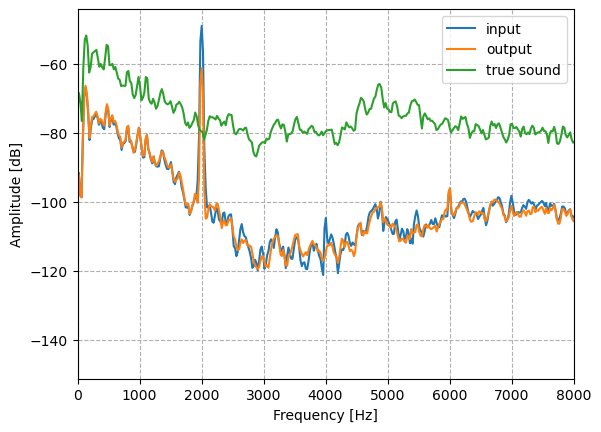

In [269]:
tx, samplerate1 = sf.read("data/P501_C_english_m1_FB_48k.wav")

freq, fft_input = sp.signal.welch(input.T[0],samplerate, nperseg=1024*2)
freq, fft_output = sp.signal.welch(output,samplerate, nperseg=1024*2)
freq1, fft_tx = sp.signal.welch(tx,samplerate1, nperseg=1024*2)
plt.plot(freq, 10*np.log10(fft_input),label='input')
plt.plot(freq, 10*np.log10(fft_output),label='output')
plt.plot(freq1, 10*np.log10(fft_tx)*1,label='true sound')
#plt.plot(freq,(fft_input),label='input')
#plt.plot(freq, (fft_output),label='output')
plt.xlim(0,8000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.grid(True, linestyle='--')
plt.savefig('plots/das_Output_signal_fft_comparison.pdf')

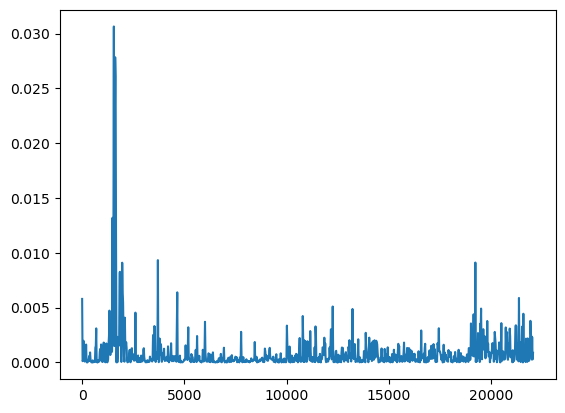

In [266]:
freq, coherence =signal.coherence(input.T[0],tx,fs=samplerate,nperseg=1024*2)
plt.plot(freq, coherence)

In [264]:
samplerate1

48000